# 设置 API Key

① 登陆 deepseek 的官方 API 文档，并点击申请 API Key。

官方文档：https://api-docs.deepseek.com/

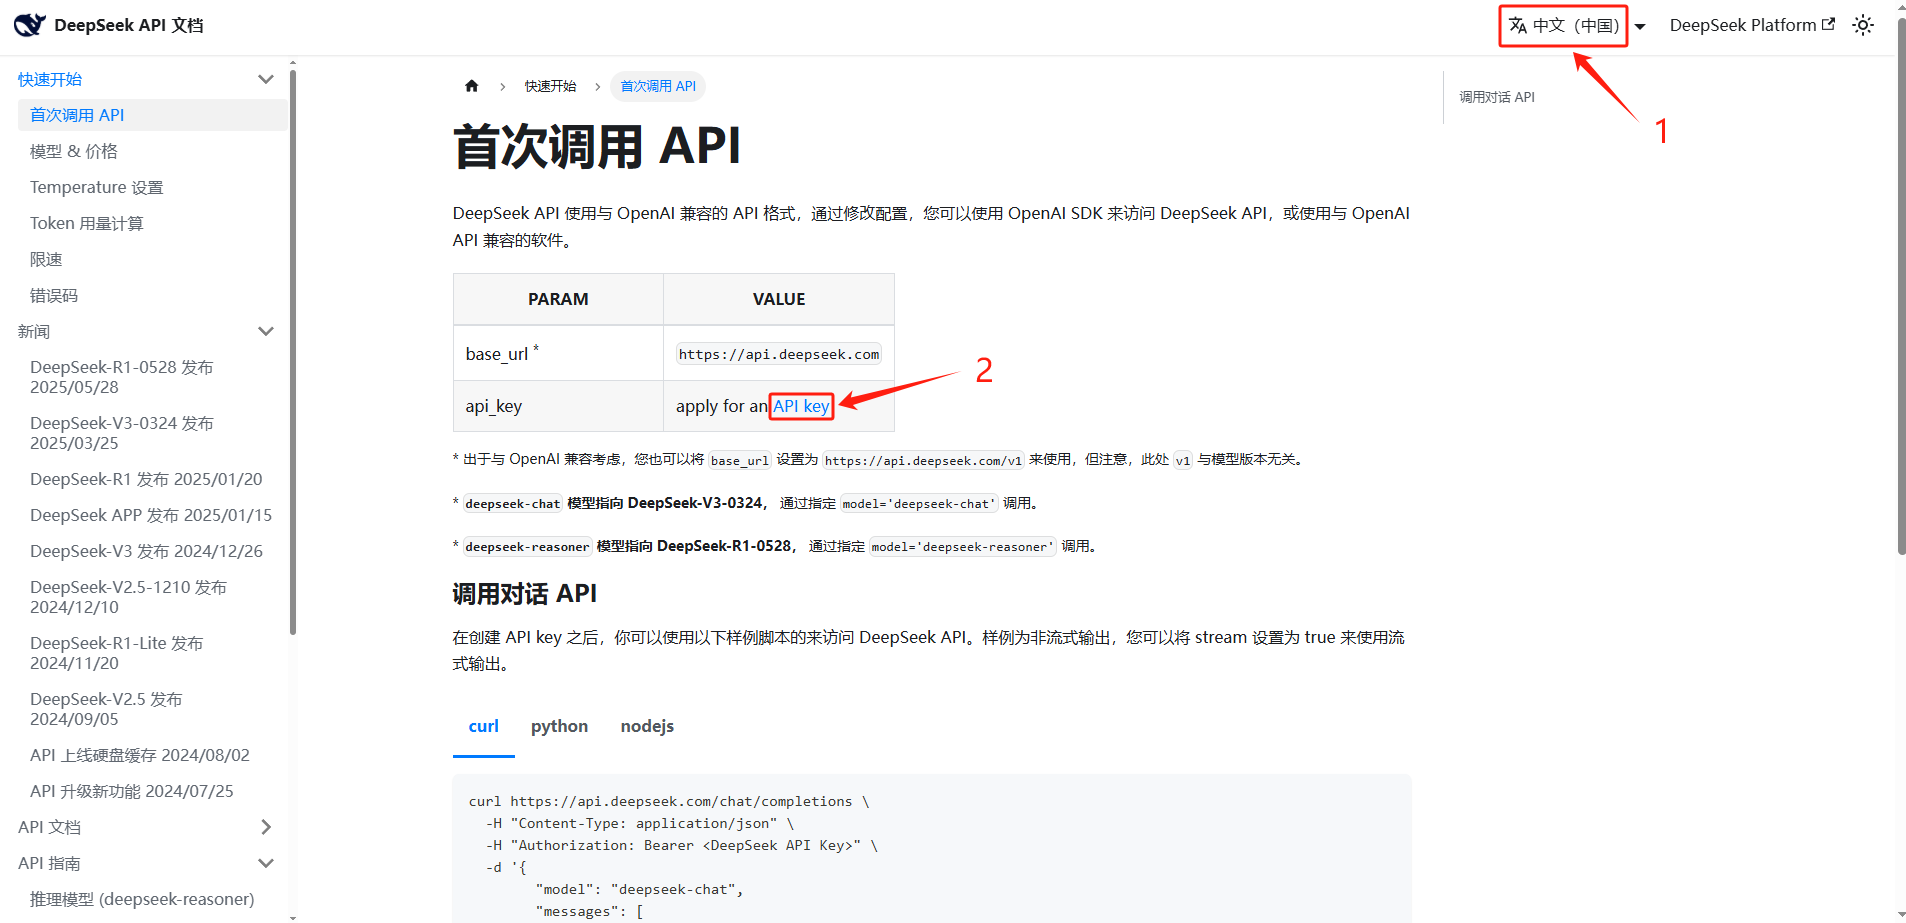

② 微信或者支付宝，给deepseek充值1块钱。

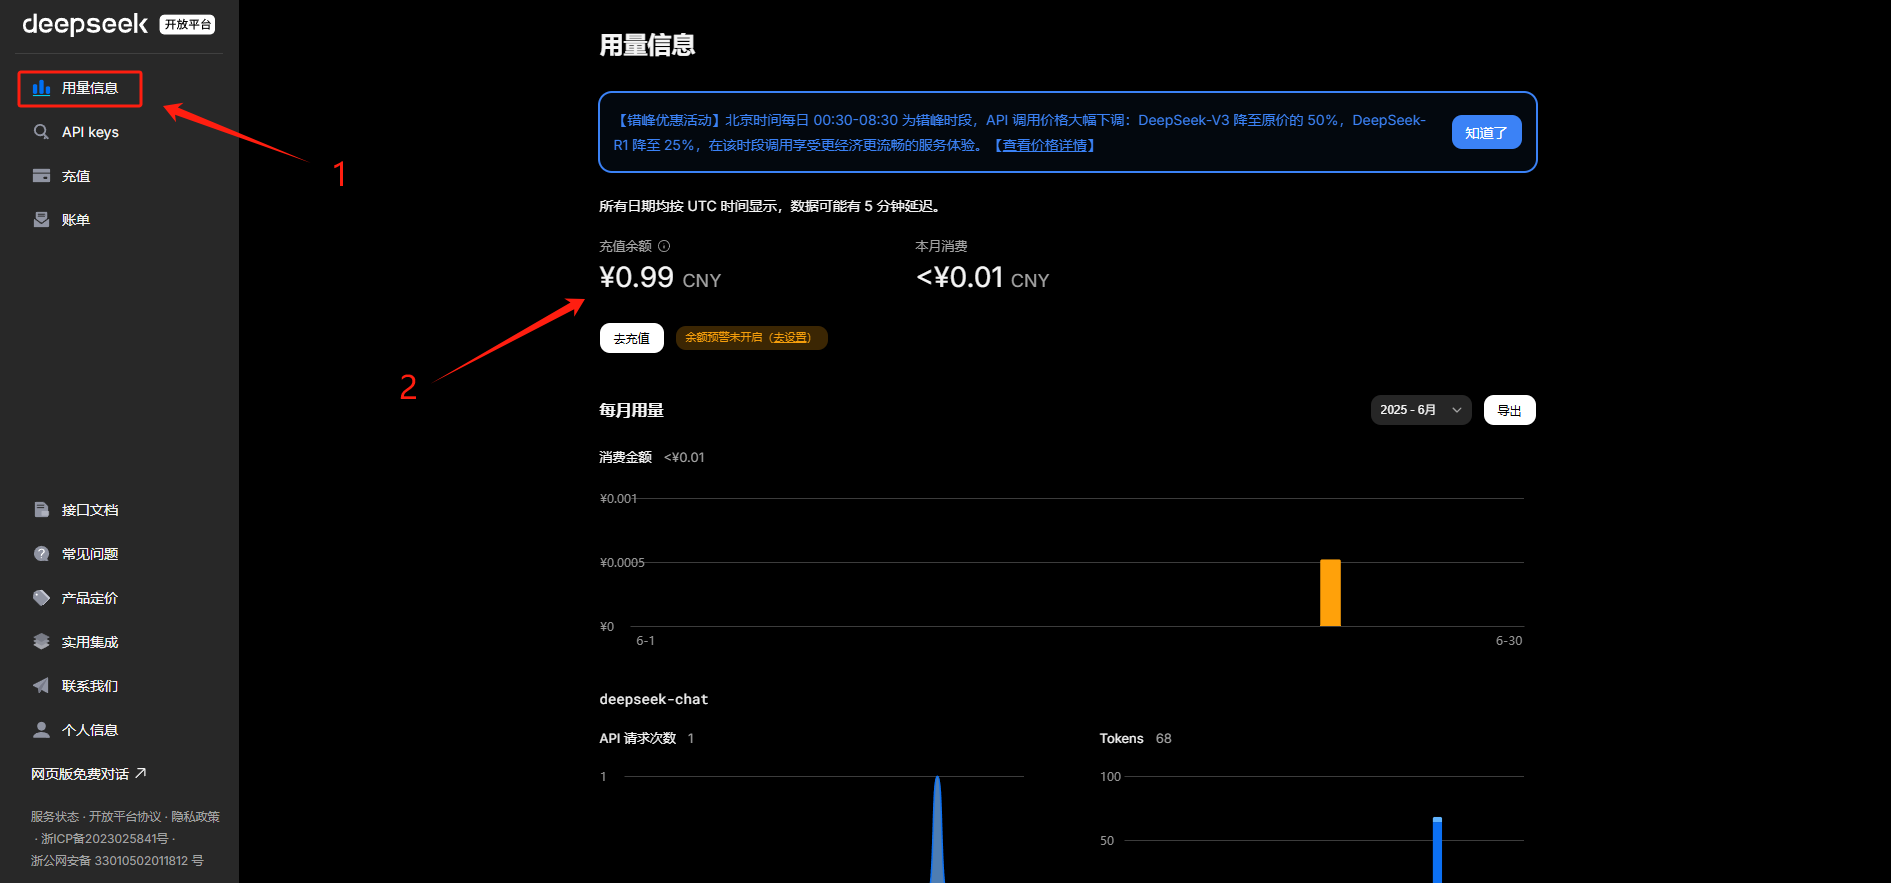

③ 进入API Keys栏，创建API Key，然后把Key的值复制一下。

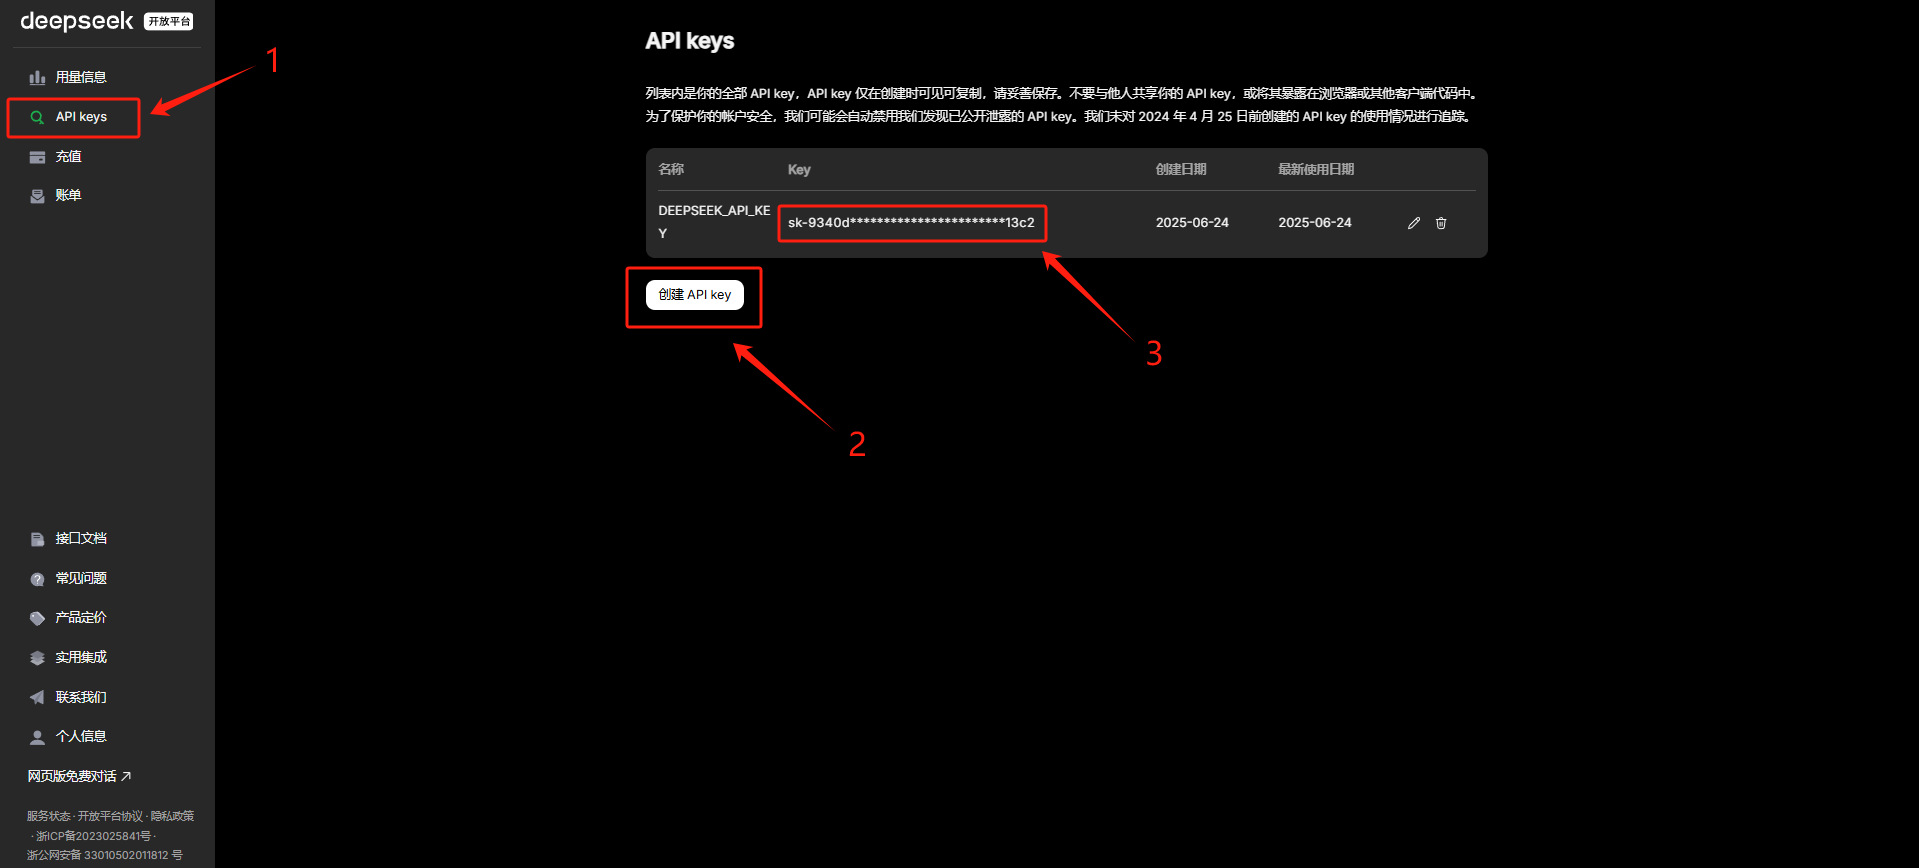

④ 左下角登录高级系统设置。

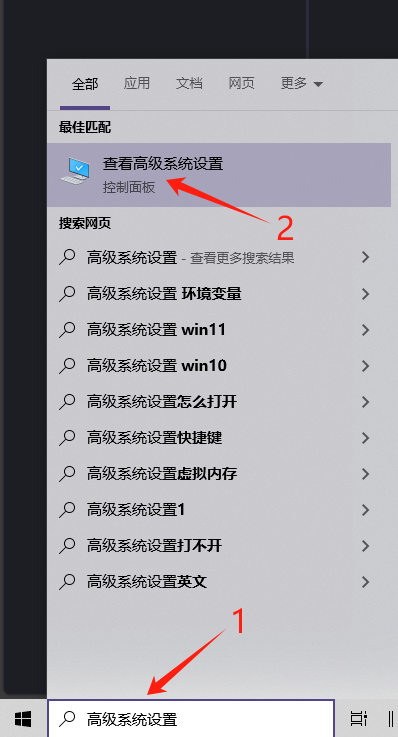

⑤ 设置环境变量，在“用户变量”里新建一个变量，变量名为 DEEPSEEK_API_KEY，值为刚才复制的 API_KEY 的值，配置完后，电脑重启一下，联网才能生效。

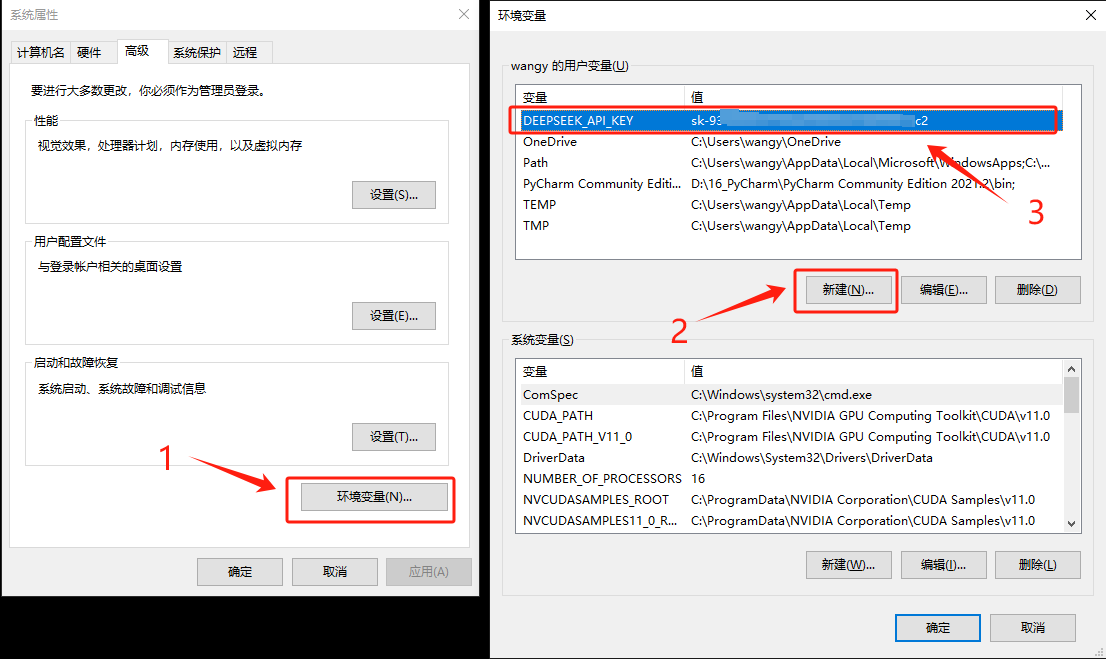

# main.py

In [1]:
"""角色：
        用户:提出问题，请求，并期望得到正确的回应、
        大模型：处理用户问题，给出回应、
        知识库:收录海量资料，根据用户问题检索关联信息
"""

# 从 openai 库中导入 OpenAI 客户端类
from openai import OpenAI
# 导入 os 模块，用于访问环境变量
import os

# 设置环境变量，从操作系统中获取名为 DEEPSEEK_API_KEY 的 API 密钥
# 该密钥需事先在操作系统中配置，例如通过 `os.environ['DEEPSEEK_API_KEY'] = 'your_key'` 或终端设置        
api_key = os.environ['DEEPSEEK_API_KEY']  

#创建一个 OpenAI 客户端对象，指定使用 DeepSeek 的 API 网关地址 和 API 密钥
client = OpenAI(base_url = 'https://api.deepseek.com', api_key = api_key) 
# client = OpenAI(base_url = 'https://api.deepseek.com', api_key = "sk-9340d89277094d5f8d55c296f66513c2") 

#发送聊天请求
completion = client.chat.completions.create(    
    model='deepseek-chat',   # 指定使用的聊天模型为 deepseek-chat
    messages=[  # 设置对话内容列表
        {
            'role': 'user',  # 角色为用户
            'content': "你是谁"  # 用户提问的内容
        }
    ],
)

# 输出模型返回的回答内容
print(completion.choices[0].message.content)

我是DeepSeek Chat，由深度求索公司（DeepSeek）开发的智能AI助手！✨ 我的使命是帮助你解答问题、提供信息、陪你聊天，还能帮你处理各种文本、文档等任务。有什么我可以帮你的吗？😊


# simple_rag_v1.py

In [2]:
# 从 openai 库中导入 OpenAI，用于调用 deepseek-chat 模型
from openai import OpenAI
# 导入 os 模块，用于读取系统环境变量
import os
# 从 pathlib 模块导入 Path，用于进行文件搜索操作
from  pathlib import Path

# 从环境变量中获取名为 DEEPSEEK_API_KEY 的密钥（你需提前设置这个环境变量）
api_key = os.environ['DEEPSEEK_API_KEY'] 

# 创建一个 OpenAI 客户端对象，设置 base_url 为 DeepSeek 的 API 地址，同时传入 API 密钥
client = OpenAI(base_url = 'https://api.deepseek.com', api_key=api_key) 

# 步骤 1：实现一个简单的“关键词匹配”检索器，用于从本地知识库中找到与 query 相关的内容
def retrieval(query):
    # 初始化 context，上下文信息字符串
    context = ''
    # 0. 遍历 my_knowledge 文件夹下所有 .txt 文件
    path_list = list(Path('my_knowledge').glob('*.txt'))

    # 1. 对每个文件进行关键词匹配判断
    for path in path_list:  
        # 如果文件名在 query 中出现（简单关键词检索）
        if path.stem in query:  
            # 2. 将相关文件的内容读取出来并追加到 context 中
            # 读取文件内容（UTF-8 编码）
            context += path.read_text(encoding='utf-8') 
            # 添加换行用于分隔多个文件内容
            context += '\n\n'

    # 返回拼接后的上下文内容
    return context

# print(retrieval('人类的定义'))

# 步骤 2：根据检索到的 context 增强查询 query，构建提示 prompt
def augmented(query, context=''):
    if not context:
        # 如果上下文为空，只返回简短的问题提示
        return f'请简要回答下面问题: {query}'
    else:
        # 如果有上下文，构建带上下文的提示，指导模型根据上下文来回答
        prompt = f'''请根据上下文信息来回答问题，如果上下文信息不足以回答问题，请直接说:‘根据上下文信息，无法回答问题’
    上下文:
    {context}
    
    问题:{query}'''

        #检查长度是否超过上下文上限
        return prompt

print(augmented('你是谁'))
print(augmented('你是谁','你是一个专业游泳教练'))

# 步骤 3：调用 deepseek-chat 模型生成回答
def generation(prompt):
    # 向模型发送聊天请求
    completion = client.chat.completions.create(    
        # 使用 DeepSeek 提供的聊天模型
        model='deepseek-chat',  
        # 消息列表，仅含一条用户提问
        messages=[  
            {
                'role': 'user',
                'content': prompt  # 用户提问内容
            }
        ],
    )
    # 返回模型回复的文本内容
    return completion.choices[0].message.content#输出结果


if __name__ == '__main__':
    
    # 示例 1：提问与知识库有关（命中）
    query = '探索者X100型无人机有多少种飞行模式？'  

    # 示例 2：提问与知识库无关（未命中）
    #query = '大飞备课过程中，有没有使用国外的资料？' 
    
    print('====== 不使用RAG=======')
    # 不带上下文直接问问题
    print(generation(query))


    print('======= 使用RAG========')
    # 使用 RAG：先从知识库检索上下文，再构建提示，再生成回答
    # 步骤 1：检索上下文
    context = retrieval(query)
    # 步骤 2：构建提示词
    prompt = augmented(query, context)
    # 步骤 3：生成回答
    resp = generation(prompt)
    # 输出结果
    print(resp)

请简要回答下面问题: 你是谁
请根据上下文信息来回答问题，如果上下文信息不足以回答问题，请直接说:‘根据上下文信息，无法回答问题’
    上下文:
    你是一个专业游泳教练

    问题:你是谁
====== 不使用RAG=======
探索者X100型无人机的飞行模式可能因厂商配置或固件版本不同而有所差异，但通常这类消费级或行业应用无人机会包含以下几种常见模式（具体以官方说明书为准）：

### 1. **基础飞行模式**
   - **GPS模式（定位模式）**  
     依赖卫星定位实现悬停稳定、自动返航及避障功能，适合新手。
   - **姿态模式（ATTI模式）**  
     仅保持水平姿态稳定，无GPS辅助，需手动控制，抗风能力较强。
   - **手动模式**  
     完全关闭飞控辅助，适合专业用户进行特技飞行。

### 2. **智能功能模式**
   - **自动返航（RTH）**  
     低电量或信号丢失时自动返回起飞点。
   - **航点飞行**  
     预设路线后无人机按路径自动飞行。
   - **跟随模式**  
     追踪移动目标（人物、车辆等）。
   - **环绕模式**  
     围绕目标点或兴趣点自动圆周飞行。

### 3. **行业应用模式**
   - **测绘模式**  
     支持网格飞行、倾斜摄影等任务规划。
   - **巡检模式**  
     针对电力、管道等场景的自动巡航。

### 4. **特殊场景模式**
   - **运动模式**  
     提升速度和操控灵敏度，适用于快速飞行。
   - **夜间模式**  
     优化灯光或传感器配置以适应低光环境。

### 注意事项：
   - 部分模式需依赖特定硬件（如视觉传感器、RTK模块等）。
   - 固件更新可能新增或调整模式功能。

**建议**：直接查阅探索者X100的官方手册或联系厂商客服获取权威信息，以确保安全和功能合规使用。
======= 使用RAG========
探索者X100型无人机有智能跟拍、轨迹飞行和一键返航三种飞行模式。
